In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
from collections import OrderedDict, defaultdict
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from mnist import MNIST, MNISTTrain, MNISTTest

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
batch_size = 1024 * 4

In [3]:
train_loader = DataLoader(dataset=MNISTTrain(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=False)


In [5]:
class Encoder(nn.Module):
    
    def __init__(self, hidden, zdim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.std_net = nn.Linear(hidden, zdim)
        self.mu_net = nn.Linear(hidden, zdim)
        
            
    def forward(self, x):
        x = x.squeeze().view(-1, 784)
        feat1 = F.relu(self.fc1(x))
        mean = self.mu_net(feat1)
        std = torch.exp(self.std_net(feat1))
        return mean, std

class Decoder(nn.Module):
    
    def __init__(self, zdim, hidden, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 784),
            )
    
    def forward(self, z):
        return self.net(z)


class VAE(nn.Module):
    
    def __init__(self, ):
        super().__init__()
        self.zdim = 50
        self.encoder = Encoder(hidden=400, zdim=self.zdim)
        self.decoder = Decoder(hidden=400, zdim=self.zdim,)
        
        self.apply(self.reset_parameters)
    
    def reset_parameters(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, )
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.)
            
    
    def forward(self, x):
        mean, std = self.encoder(x)
        ## TODO error 
        # z = torch.normal(mean.clone().detach(), std.detach().clone())
        # z = torch.normal(mean, std)
        z = torch.distributions.Normal(mean, std).rsample()
        x_hat = self.decoder(z)
        return mean, std, z, x_hat

def log_normal_prob(x, mean, std, epsilon=1e-9):
    # Log normal for diagonal normal dist
    variance = std ** 2
    D = mean.size(-1)
    log_prob = -(D/2) * torch.log(torch.tensor(2*torch.pi)) - 0.5 * torch.log(variance + epsilon).sum(1) - 0.5 * ((x - mean).square() / (variance + epsilon)).sum(1)
    # print("Log prob: ",log_prob.size())
    return log_prob
    

class Criterion(nn.Module):
    
    def __init__(self, alpha_loss=1.0):
        super().__init__()
        self.alpha_loss = alpha_loss
        
        
    def forward(self, input, target, mean, std, z):
        reconstruction_loss = F.binary_cross_entropy_with_logits(input.view(input.size(0), -1), target.view(target.size(0), -1), reduction="none").sum(-1)
        assert mean.size(1) == 50
        # print(mean.size(), mean.dim)
        assert mean.dim() == 2
        kl_loss = 0.5 * (mean.square().sum(axis=1) + std.square().sum(axis=1) - mean.size(1) - 2 * torch.log(std).sum(axis=1))
        assert kl_loss.size() == torch.Size([mean.size(0)])
        assert reconstruction_loss.size() == torch.Size([mean.size(0)])
        loss = reconstruction_loss + self.alpha_loss * kl_loss
        # raise Exception
        return loss.mean()
    

In [6]:

def train():
    model = VAE().cuda()
    criterion = Criterion()
    model.train()
    # optimizer = optim.Adam(model.parameters(), lr=3e-5)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98) 
    epochs = 100
    losses = []
    it = 0
    for i in range(epochs):
        print("Starting Epoch ", i, "...")
        for j, (img, label) in enumerate(train_loader):
            img = img.cuda()
            img /= 255.0
            mean, std, z, out = model(img)
            out = out.view(img.size())
            loss = criterion(out, img, mean, std, z)
            optimizer.zero_grad()
            loss.backward()
            it += 1
            nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
            losses.append(loss.item())
            if it % 50 == 0:
                print(f"Epoch: {i}, batch: {j}, loss: {np.mean(losses[-100:])}")
        scheduler.step()

    return model, losses
    
        

In [7]:
model, losses = train()

Starting Epoch  0 ...
Epoch: 0, batch: 49, loss: 403.4158709716797
Starting Epoch  1 ...
Epoch: 1, batch: 40, loss: 332.38457443237303
Starting Epoch  2 ...
Epoch: 2, batch: 31, loss: 241.23819778442382
Starting Epoch  3 ...
Epoch: 3, batch: 22, loss: 211.50779037475587
Starting Epoch  4 ...
Epoch: 4, batch: 13, loss: 197.33590133666993
Starting Epoch  5 ...
Epoch: 5, batch: 4, loss: 189.92350875854493
Epoch: 5, batch: 54, loss: 184.93912704467775
Starting Epoch  6 ...
Epoch: 6, batch: 45, loss: 181.31130981445312
Starting Epoch  7 ...
Epoch: 7, batch: 36, loss: 178.4942463684082
Starting Epoch  8 ...
Epoch: 8, batch: 27, loss: 176.03979888916015
Starting Epoch  9 ...
Epoch: 9, batch: 18, loss: 173.8741424560547
Starting Epoch  10 ...
Epoch: 10, batch: 9, loss: 171.9479081726074
Starting Epoch  11 ...
Epoch: 11, batch: 0, loss: 170.18892318725585
Epoch: 11, batch: 50, loss: 168.5830241394043
Starting Epoch  12 ...
Epoch: 12, batch: 41, loss: 167.24353469848631
Starting Epoch  13 ...
Ep

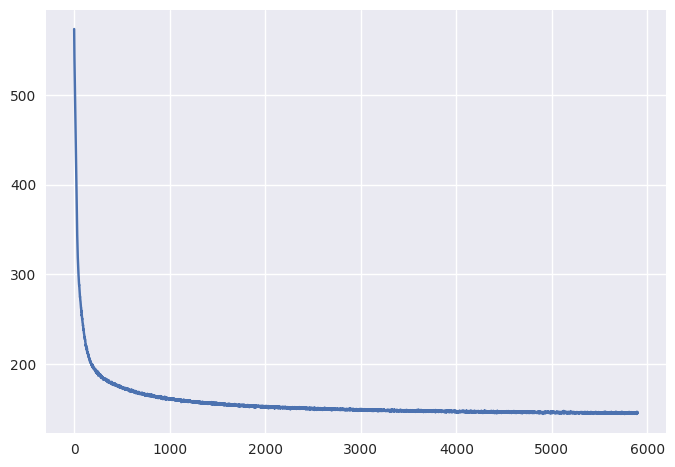

In [8]:
plt.plot(losses)

In [9]:
def plot_images(model, idx, nsamples=1000):
    with torch.no_grad():
        model.eval()
        img,label = test_loader.dataset[idx]
        img = img.unsqueeze(0).cuda()
        img /= 255.0
        mean, std, z, out = model(img.expand(nsamples, -1, -1, -1, -1))
        out = out.mean(axis=0)
        out = out.view(img.size())
        out = out[0].detach().cpu().permute(1, 2, 0)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu())
        ax2.imshow(torch.sigmoid(out))
        fig.suptitle(label.item())

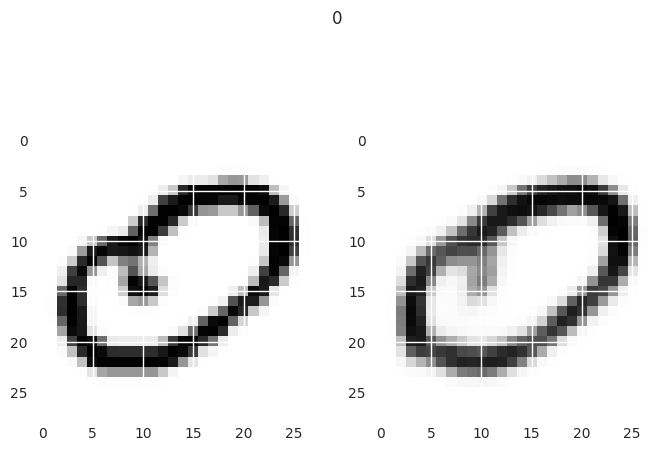

In [10]:
plot_images(model, 0)

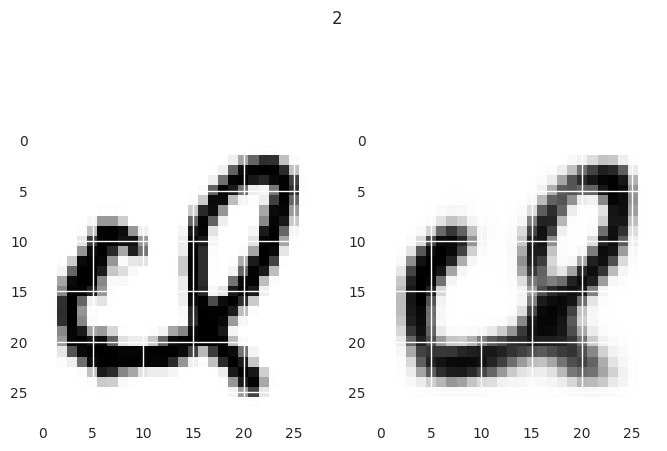

In [11]:
plot_images(model, 2456)

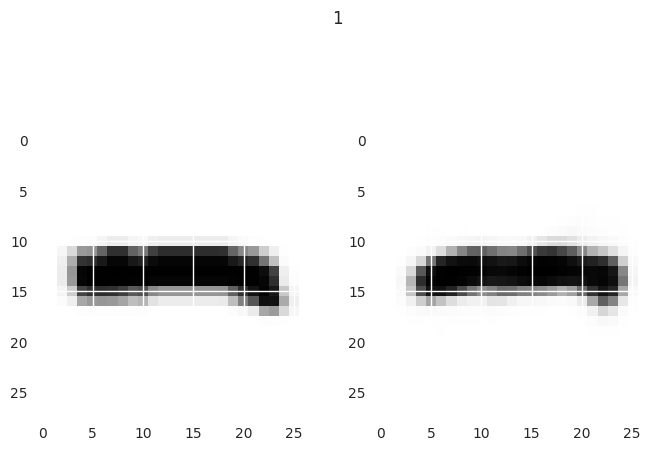

In [12]:
plot_images(model, 333, 1)

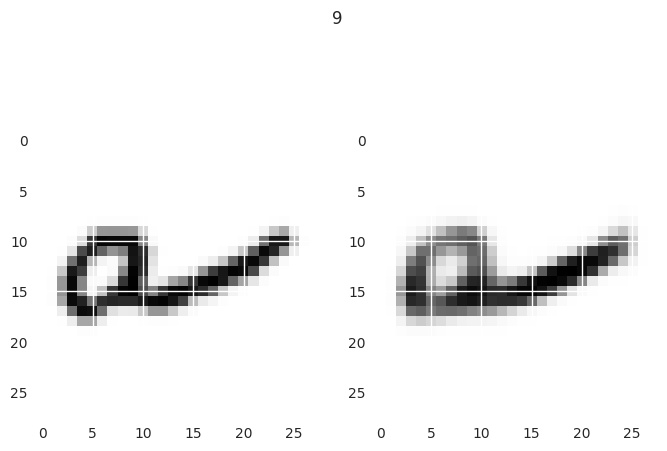

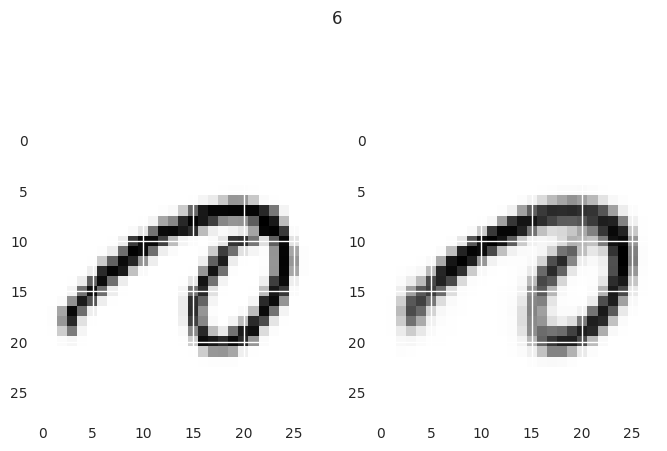

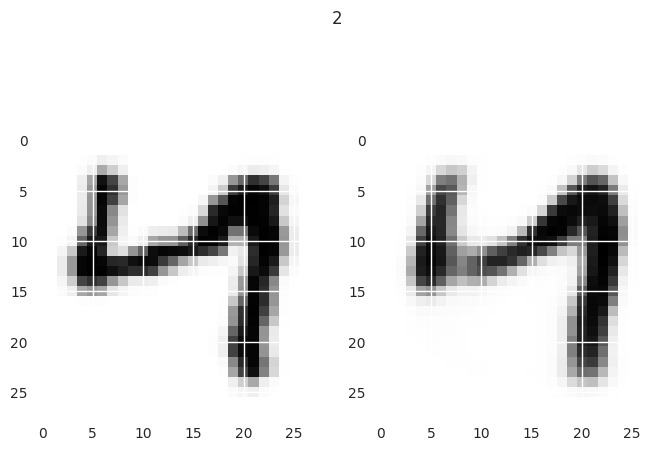

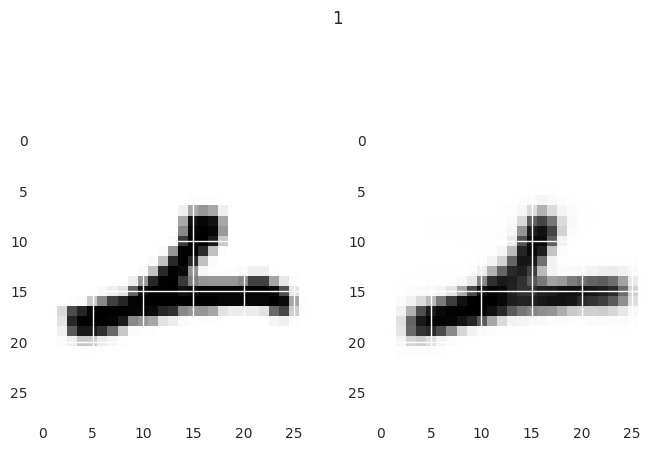

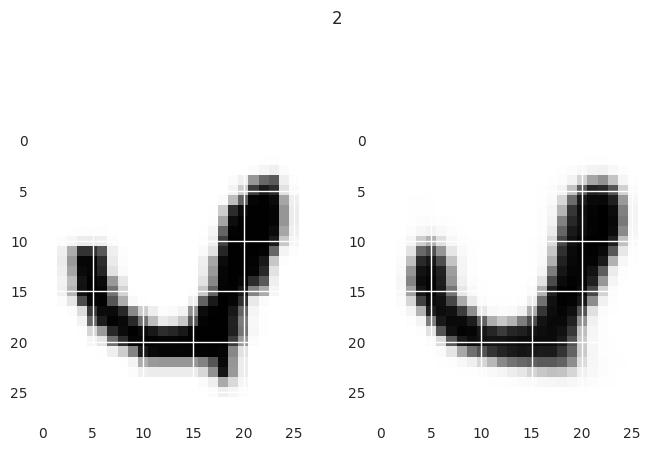

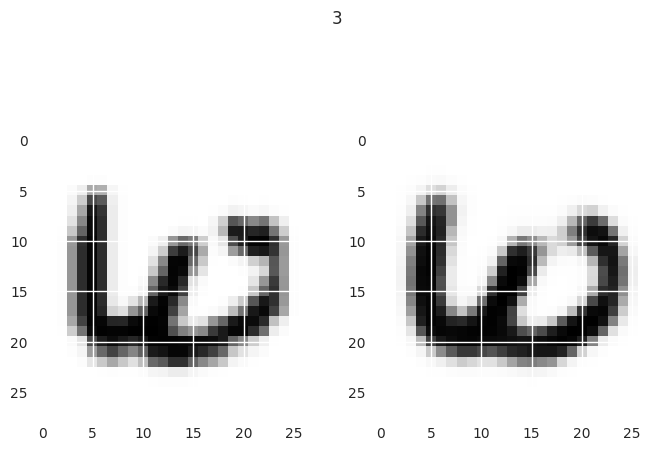

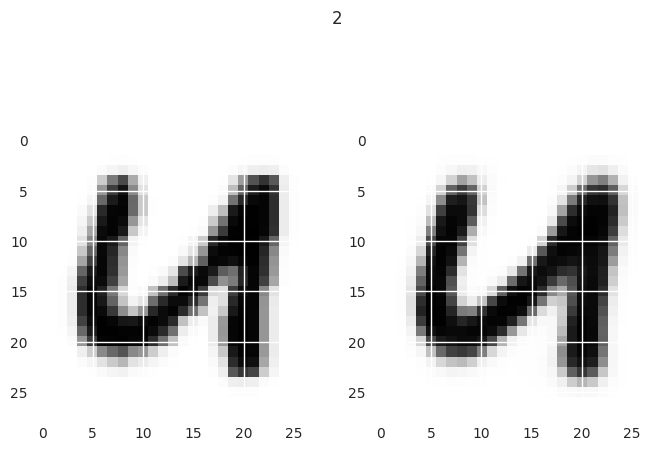

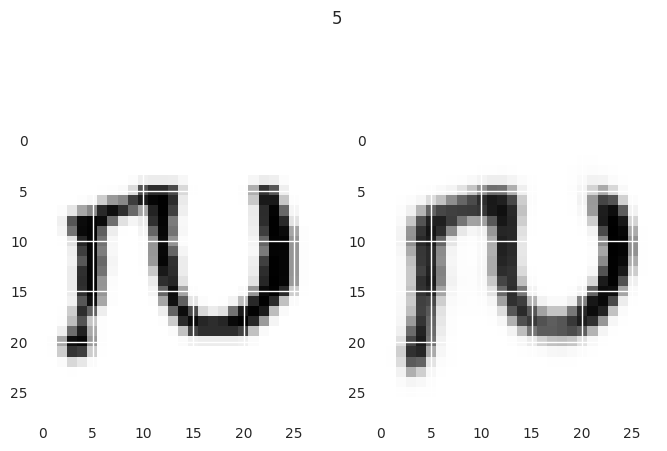

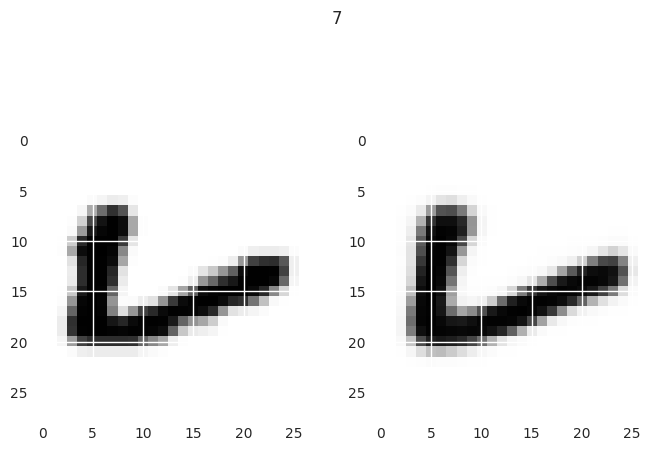

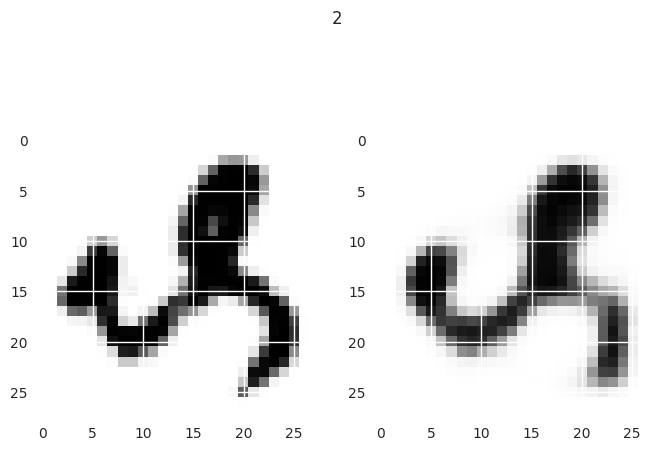

In [13]:
for j in torch.randint(5000, 9999, (10,)):
    plot_images(model, j, 2000)

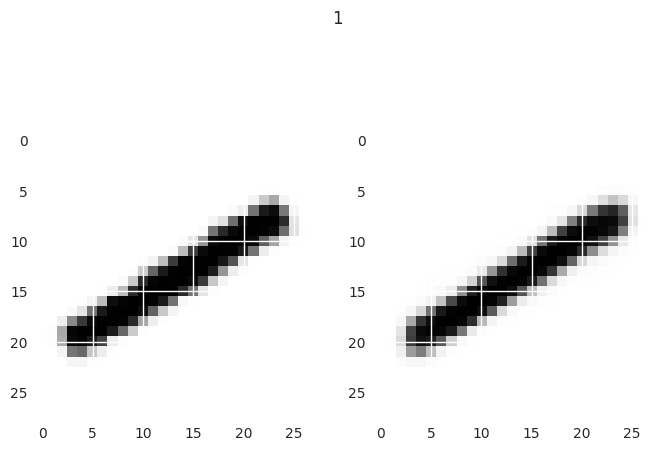

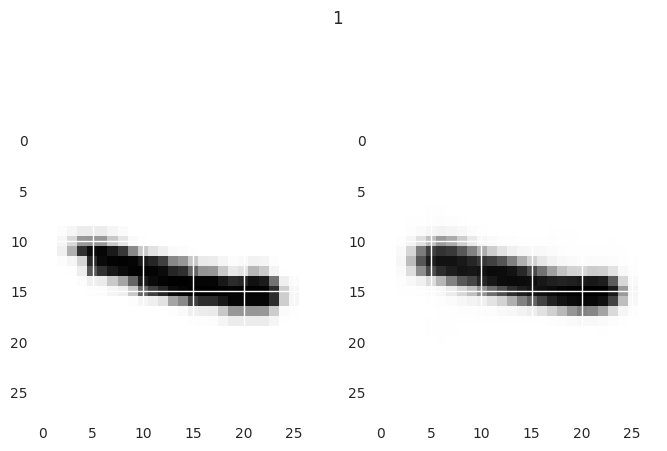

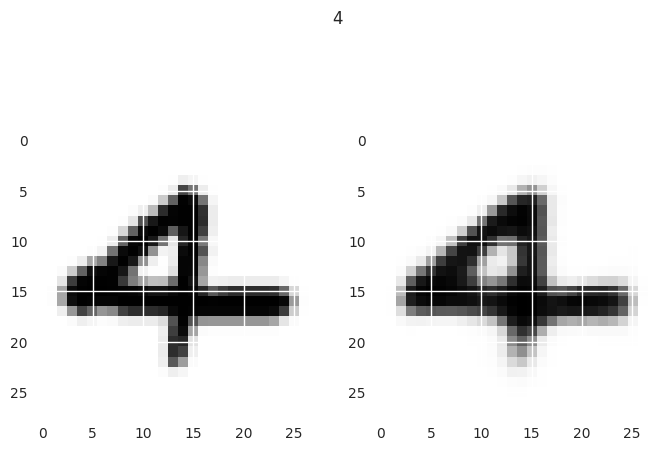

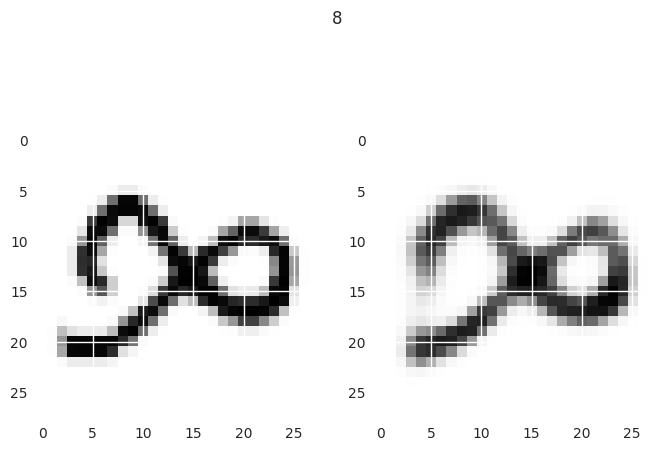

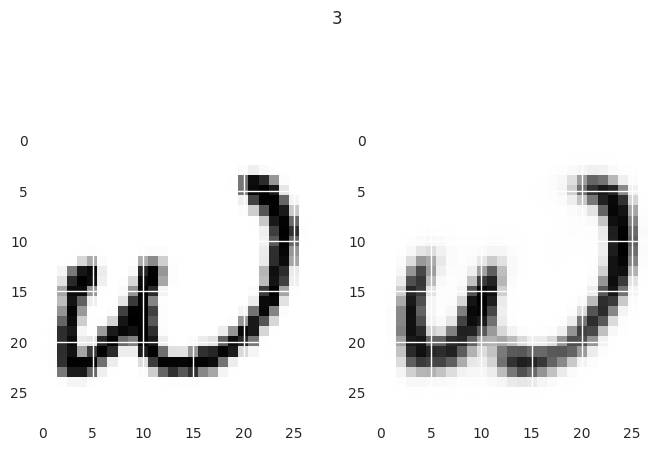

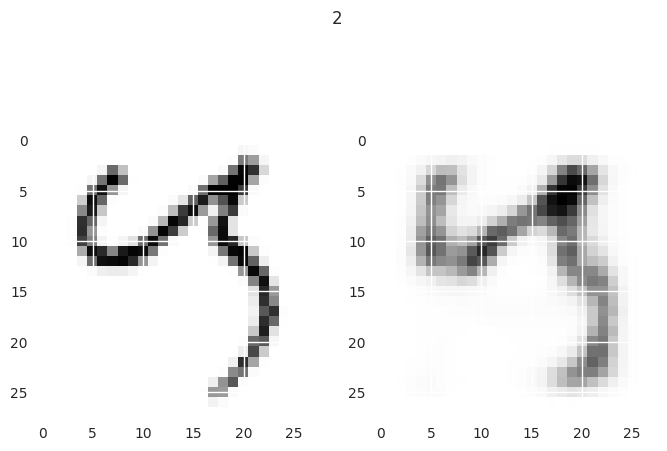

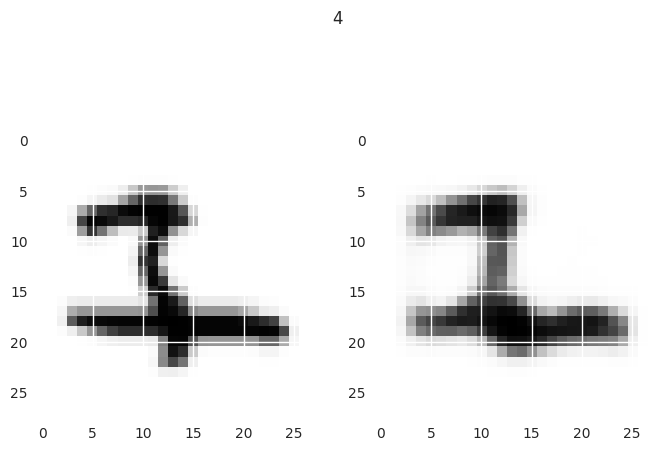

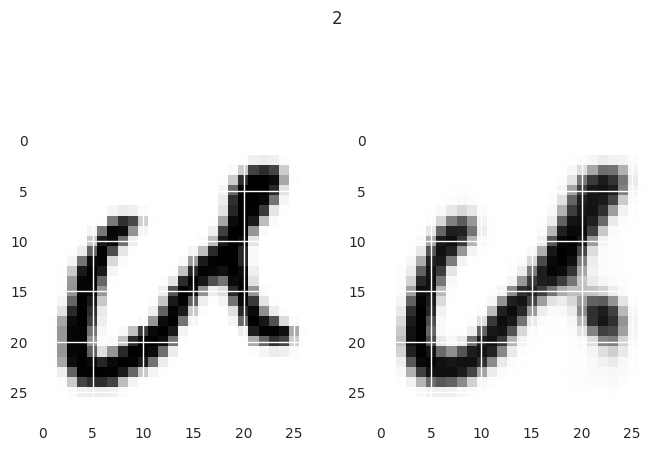

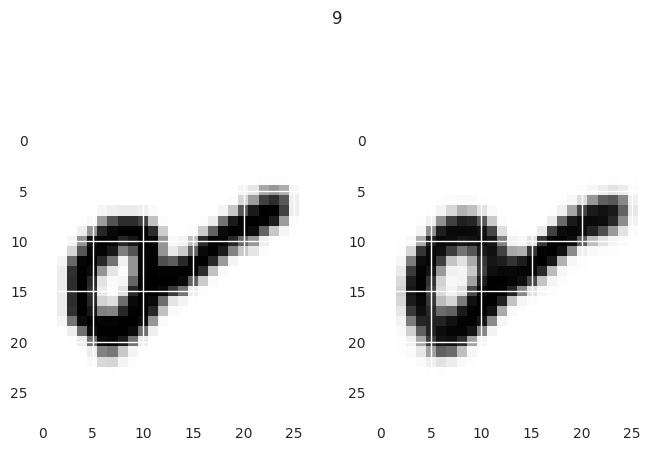

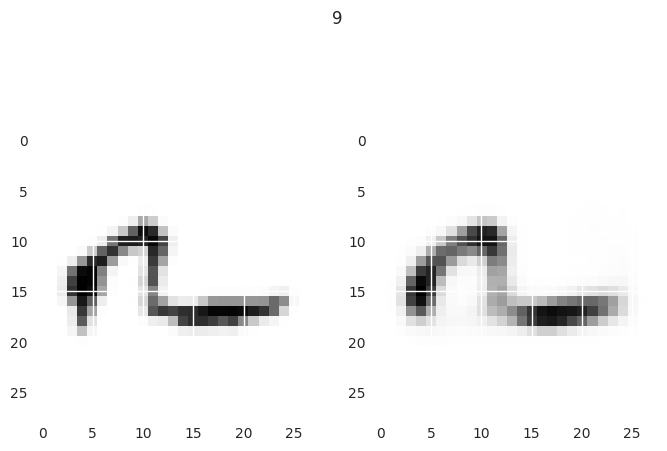

In [14]:
for j in torch.randint(5000, 9999, (10,)):
    plot_images(model, j, 2000)